In [ ]:
!pip install -q tensorflow matplotlib pandas scikit-learn seaborn

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import zipfile
import time
import warnings
warnings.filterwarnings('ignore')

# Random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3  # Keep RGB (no grayscaling)

In [ ]:
!mkdir -p GTSRB

# Download the training data
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P GTSRB/

# Download the test data
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P GTSRB/

# Download the test data ground truth
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P GTSRB/

with zipfile.ZipFile('GTSRB/GTSRB_Final_Training_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('GTSRB/')

with zipfile.ZipFile('GTSRB/GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('GTSRB/')

with zipfile.ZipFile('GTSRB/GTSRB_Final_Test_GT.zip', 'r') as zip_ref:
    zip_ref.extractall('GTSRB/')

print("GTSRB dataset downloaded and extracted successfully!")

--2025-05-22 11:17:48--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB/GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M   198MB/s    in 1.3s    

2025-05-22 11:17:49 (198 MB/s) - ‘GTSRB/GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2025-05-22 11:17:50--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB/GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[==========

In [ ]:
# Define all 43 traffic sign classes
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

print(f"Total number of traffic sign classes: {len(classes)}")

# Paths for GTSRB dataset
training_dir = 'GTSRB/GTSRB/Final_Training/Images'
test_dir = 'GTSRB/GTSRB/Final_Test/Images'
test_gt_file = 'GTSRB/GT-final_test.csv'

Total number of traffic sign classes: 43


In [ ]:
def load_training_data():
    images = []
    labels = []

    # Loop through all 43 classes
    for class_id in range(43):
        class_folder = f"{class_id:05d}"
        class_path = os.path.join(training_dir, class_folder)

        if not os.path.isdir(class_path):
            print(f"Warning: Class {class_id} folder not found")
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith('.ppm')]
        print(f"Loading {len(image_files)} images for class {class_id}: {classes[class_id]}")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(class_id)

    X = np.array(images)
    # Preprocess images using MobileNet's preprocess_input
    X = preprocess_input(X)
    y = np.array(labels)
    return X, y

# Load all training data
print("Loading training data...")
X_train_full, y_train_full = load_training_data()
print(f"\nTotal dataset size: {X_train_full.shape[0]} images")
print(f"Image dimensions: {X_train_full.shape[1:3]}")

Loading training data...
Loading 210 images for class 0: Speed limit (20km/h)
Loading 2220 images for class 1: Speed limit (30km/h)
Loading 2250 images for class 2: Speed limit (50km/h)
Loading 1410 images for class 3: Speed limit (60km/h)
Loading 1980 images for class 4: Speed limit (70km/h)
Loading 1860 images for class 5: Speed limit (80km/h)
Loading 420 images for class 6: End of speed limit (80km/h)
Loading 1440 images for class 7: Speed limit (100km/h)
Loading 1410 images for class 8: Speed limit (120km/h)
Loading 1470 images for class 9: No passing
Loading 2010 images for class 10: No passing veh over 3.5 tons
Loading 1320 images for class 11: Right-of-way at intersection
Loading 2100 images for class 12: Priority road
Loading 2160 images for class 13: Yield
Loading 780 images for class 14: Stop
Loading 630 images for class 15: No vehicles
Loading 420 images for class 16: Veh > 3.5 tons prohibited
Loading 1110 images for class 17: No entry
Loading 1200 images for class 18: Gener

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=43)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=43)

print(f"Training set: {X_train.shape[0]} images ({100 * X_train.shape[0] / X_train_full.shape[0]:.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({100 * X_val.shape[0] / X_train_full.shape[0]:.1f}%)")

Training set: 31367 images (80.0%)
Validation set: 7842 images (20.0%)


In [ ]:
# Define MobileNetV1 with alpha=0.25 (MobileNetV1_25)
def create_mobilenetv1_25(input_shape, num_classes=43):
    # Create the base model with random initialization
    base_model = MobileNet(
        input_shape=input_shape,
        alpha=0.20,  # Width multiplier - matches the book's mobilenet_v1_025
        depth_multiplier=1,
        dropout=0.001,
        include_top=False,  # We'll add our own top layer
        weights=None  # Start with random weights
    )

    # Add global average pooling and classification layer
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model with 43 classes
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = create_mobilenetv1_25(input_shape, num_classes=43)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 16, 16, 6)      │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 16, 16, 6)      │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 16, 16, 6)      │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 16, 16, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 16, 16, 12)     │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 16, 16, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 17, 17, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 8, 8, 12)       │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 8, 8, 12)       │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 8, 8, 25)       │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 8, 8, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 8, 8, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 8, 8, 25)       │           225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 8, 8, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 8, 8, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 8, 8, 25)       │           625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 8, 8, 25)       │           100 │
│ (BatchNormalization)            │                        │             

 Total params: 151,074 (590.13 KB)

 Trainable params: 146,722 (573.13 KB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
# Learning rate parameters to match the TinyML approach
initial_learning_rate = 0.045
lr_decay_factor = 0.98
batch_size = 96
steps_per_epoch = len(X_train) // batch_size
num_epochs_per_decay = 2.5

# Create learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=int(num_epochs_per_decay * steps_per_epoch),
    decay_rate=lr_decay_factor,
    staircase=True
)

# Compile with TinyML parameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Set up callbacks
callbacks = [
    # Save the best model based on validation accuracy
    tf.keras.callbacks.ModelCheckpoint(
        'best_mobilenetv1_25_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    # Add TensorBoard for visualization
    tf.keras.callbacks.TensorBoard(
        log_dir='logs',
        update_freq='epoch'
    ),
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# Set number of epochs
epochs = 20

# Print training info
print(f"Training with {len(X_train)} samples")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Initial learning rate: {initial_learning_rate}")

Training with 31367 samples
Batch size: 96
Steps per epoch: 326
Initial learning rate: 0.045


In [ ]:
# Record the start time
start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_onehot),
    callbacks=callbacks,
    verbose=1
)

# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save the final model
model.save('mobilenetv1_25_traffic_signs_final.h5')
print("Final model saved to 'mobilenetv1_25_traffic_signs_final.h5'")

Epoch 1/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0988 - loss: 3.5306
Epoch 1: val_accuracy improved from -inf to 0.15838, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.0990 - loss: 3.5292 - val_accuracy: 0.1584 - val_loss: 3.9084
Epoch 2/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4191 - loss: 2.1807
Epoch 2: val_accuracy improved from 0.15838 to 0.22673, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.4193 - loss: 2.1803 - val_accuracy: 0.2267 - val_loss: 4.9205
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6205 - loss: 1.6944
Epoch 3: val_accuracy improved from 0.22673 to 0.30196, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.6206 - loss: 1.6942 - val_accuracy: 0.3020 - val_loss: 3.9193
Epoch 4/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7357 - loss: 1.4230
Epoch 4: val_accuracy improved from 0.30196 to 0.32390, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.7357 - loss: 1.4229 - val_accuracy: 0.3239 - val_loss: 3.4702
Epoch 5/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7956 - loss: 1.2902
Epoch 5: val_accuracy improved from 0.32390 to 0.46672, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.7957 - loss: 1.2901 - val_accuracy: 0.4667 - val_loss: 2.5064
Epoch 6/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 1.1898
Epoch 6: val_accuracy improved from 0.46672 to 0.73030, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.8400 - loss: 1.1897 - val_accuracy: 0.7303 - val_loss: 1.5852
Epoch 7/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8599 - loss: 1.1337
Epoch 7: val_accuracy did not improve from 0.73030
327/327 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.8599 - loss: 1.1337 - val_accuracy: 0.6491 - val_loss: 1.7788
Epoch 8/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8754 - loss: 1.0874
Epoch 8: val_accuracy did not improve from 0.73030
327/327 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.8754 - loss: 1.0874 - val_accuracy: 0.7251 - val_loss: 1.5572
Epoch 9/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8871 - loss: 1.0616
Epoch 9: val_accuracy improved from 0.73030 to 0.80349, saving model to best_mobilenetv1_25_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.8871 - loss: 1.0616 - val_accuracy: 0.8035 - val_loss: 1.3396
Epoch 10/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9018 - loss: 1.0289
Epoch 10: val_accuracy did not improve from 0.80349
327/327 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step - accuracy: 0.9018 - loss: 1.0289 - val_accuracy: 0.7300 - val_loss: 1.5686
Epoch 11/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9104 - loss: 1.0015
Epoch 11: val_accuracy did not improve from 0.80349
327/327 ━━━━━━━━━━━━━━━━━━━━ 70s 110ms/step - accuracy: 0.9103 - loss: 1.0015 - val_accuracy: 0.5936 - val_loss: 1.9746
Epoch 12/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9102 - loss: 1.0033
Epoch 12: val_accuracy did not improve from 0.80349
327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9102 - loss: 1.0033 - val_accuracy: 0.7858 - val_loss: 1.3537
Epoch 13/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9173 - loss: 0.9839
Epoch 13

327/327 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9301 - loss: 0.9498 - val_accuracy: 0.8768 - val_loss: 1.1125
Epoch 20/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9450 - loss: 0.8985
Epoch 20: val_accuracy did not improve from 0.87682
327/327 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.9450 - loss: 0.8985 - val_accuracy: 0.8176 - val_loss: 1.2947
Restoring model weights from the end of the best epoch: 19.


Training completed in 870.01 seconds (14.50 minutes)
Final model saved to 'mobilenetv1_25_traffic_signs_final.h5'


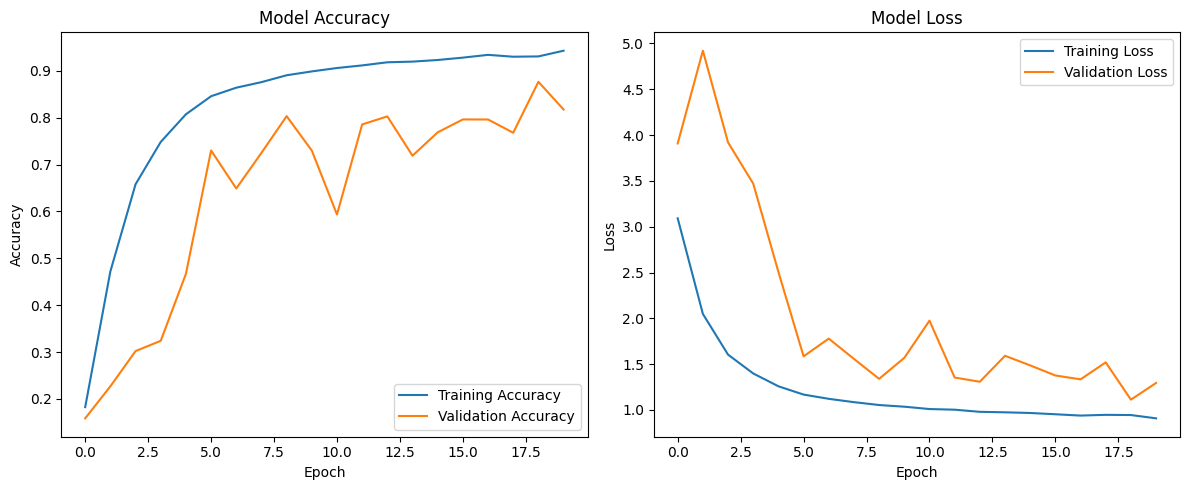

Best Model Results (at epoch 19):
Training Accuracy: 0.9310
Validation Accuracy: 0.8768


In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Get the best epoch's results
best_epoch = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]

print(f"Best Model Results (at epoch {best_epoch+1}):")
print(f"Training Accuracy: {best_train_acc:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

Loaded best model for evaluation.
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8731 - loss: 1.1219
Validation Accuracy: 0.8768
Validation Loss: 1.1125
Loading official test set images for 12630 samples...
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8175 - loss: 1.3179
Official Test Set Accuracy: 0.8146
Official Test Set Loss: 1.3177
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.25      0.39        60
           1       0.76      0.92      0.83       720
           2       0.89      0.75      0.82       750
           3       0.87      0.85      0.86       450
           4       0.90      0.87      0.89       660
           5       0.68      0.87      0.76       630
           6       0.68      0.55      0.61       150
           7       0.81      0.80      0.81       450
           8       0.84      0.87      0.86       450
           9       0.90      0.96  

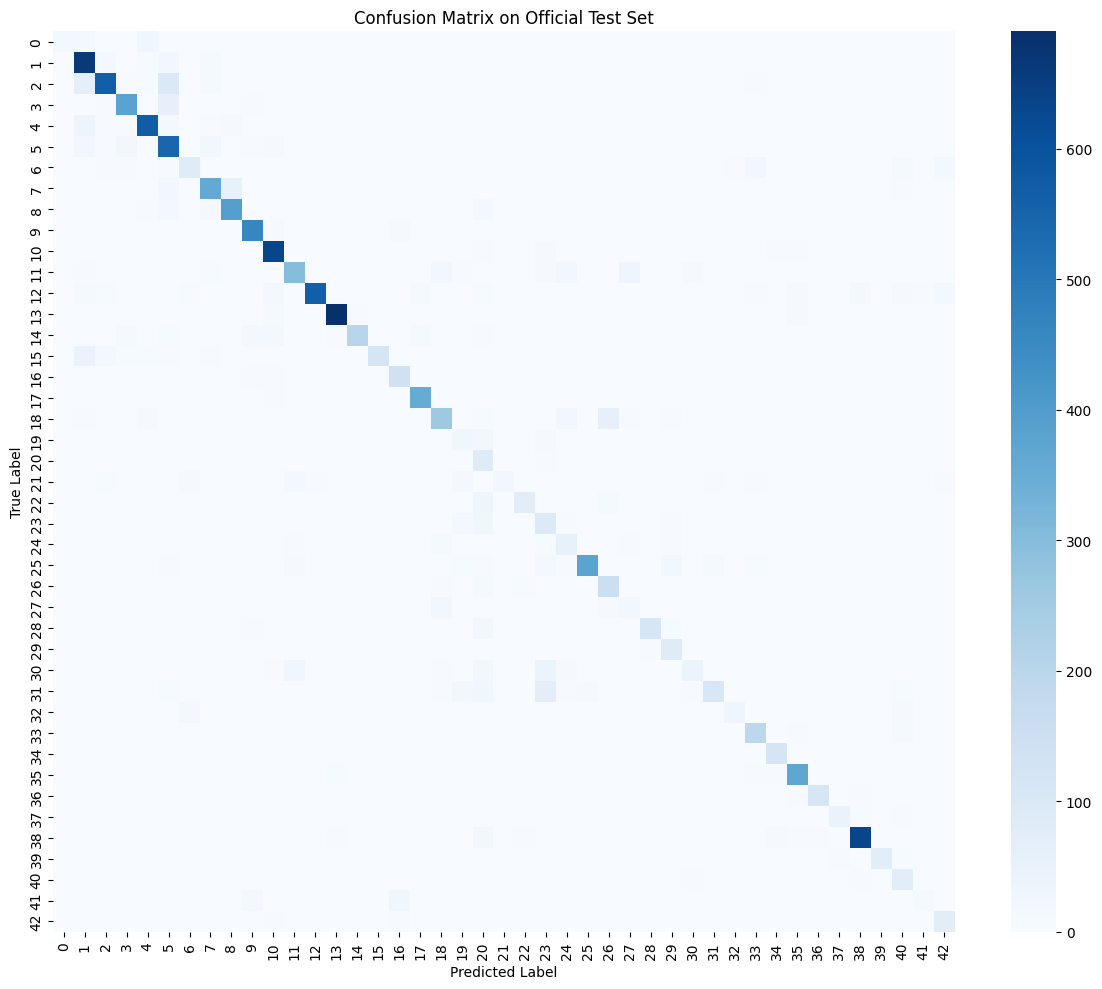

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('best_mobilenetv1_25_model.h5')
print("Loaded best model for evaluation.")

# Evaluate on validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val_onehot, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Load and parse the test set ground truth
test_gt_path = 'GTSRB/GT-final_test.csv'
test_gt = pd.read_csv(test_gt_path, sep=';')

# Load the test images
X_test_official = []
y_test_official = []

print(f"Loading official test set images for {len(test_gt)} samples...")
for index, row in test_gt.iterrows():
    if index == 0:  # Skip header row if present
        continue
    img_path = os.path.join('GTSRB/GTSRB/Final_Test/Images', row['Filename'])
    class_id = row['ClassId']

    # Load and preprocess the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Add to our dataset
    X_test_official.append(img)
    y_test_official.append(class_id)

# Convert to numpy arrays
X_test_official = np.array(X_test_official)
y_test_official = np.array(y_test_official)

# Preprocess the images same as training
X_test_official = preprocess_input(X_test_official)

# One-hot encode the test labels
y_test_official_onehot = tf.keras.utils.to_categorical(y_test_official, num_classes=43)

# Evaluate on the official test set
test_loss, test_acc = best_model.evaluate(X_test_official, y_test_official_onehot, verbose=1)
print(f"Official Test Set Accuracy: {test_acc:.4f}")
print(f"Official Test Set Loss: {test_loss:.4f}")

# Make predictions
y_pred = np.argmax(best_model.predict(X_test_official), axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_official, y_pred))

# Create confusion matrix for visualization
cm = confusion_matrix(y_test_official, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Official Test Set')
plt.tight_layout()
plt.show()

In [ ]:
print("Original TensorFlow model analysis:")
# Get the TensorFlow model size (original h5 file)
tf_model_size_kb = os.path.getsize('best_mobilenetv1_25_model.h5') / 1024
tf_model_size_mb = tf_model_size_kb / 1024
print(f"TensorFlow model size: {tf_model_size_kb:.2f} KB ({tf_model_size_mb:.2f} MB)")

# We already know the original TF model's accuracy on the test set
tf_model_acc = test_acc  # This is from our previous evaluation in cell 9
print(f"TensorFlow model accuracy on test set: {tf_model_acc*100:.2f}%")

# Function to print model size in KB
def get_model_size(file_path):
    return os.path.getsize(file_path) / 1024  # Size in KB

# Define representative dataset function for quantization
def representative_data_gen():
    for i in range(min(500, len(X_train))):  # Use up to 500 samples for calibration
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]

Original TensorFlow model analysis:
TensorFlow model size: 2090.94 KB (2.04 MB)
TensorFlow model accuracy on test set: 81.46%


In [ ]:
# 1. Convert to regular TFLite (float32)
print("Converting model to standard TensorFlow Lite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open('traffic_sign_model.tflite', 'wb') as f:
    f.write(tflite_model)
float_model_size = get_model_size('traffic_sign_model.tflite')
print(f"TFLite model size: {float_model_size:.2f} KB ({float_model_size/1024:.2f} MB)")
print(f"Size reduction from TensorFlow: {(1 - float_model_size/tf_model_size_kb) * 100:.1f}%")

Converting model to standard TensorFlow Lite format...
Saved artifact at '/tmp/tmpnk1w0__8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  136805839795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805821387344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805821384848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805839797712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136805821384656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804643112720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804643111184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804643110992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804643111376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804643111760: TensorSpec(sha

In [ ]:
# 2. Integer-Only Quantization (everything quantized)
print("Converting model using Integer-Only Quantization...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_int8_model = converter.convert()
with open('traffic_sign_model_int8.tflite', 'wb') as f:
    f.write(tflite_int8_model)
int8_model_size = get_model_size('traffic_sign_model_int8.tflite')
print(f"Integer-only quantized model size: {int8_model_size:.2f} KB ({int8_model_size/1024:.2f} MB)")
print(f"Size reduction from TensorFlow: {(1 - int8_model_size/tf_model_size_kb) * 100:.1f}%")
print(f"Size reduction from TFLite: {(1 - int8_model_size/float_model_size) * 100:.1f}%")

In [ ]:
# Function to evaluate TFLite model accuracy
def evaluate_tflite_model(tflite_model_path, test_images, test_labels, name="Unknown"):
    """
    Evaluate a TFLite model on the test set
    """
    print(f"\nEvaluating {name} model...")
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check if the model is quantized
    is_quantized = input_details[0]['dtype'] == np.int8

    # Get quantization parameters if available
    if is_quantized:
        input_scale, input_zero_point = input_details[0]['quantization']
        print(f"Input quantization: scale={input_scale}, zero_point={input_zero_point}")

    # Initialize variables for accuracy calculation
    correct = 0
    total_time = 0
    total_samples = len(test_images)

    # Limit evaluation to a reasonable number of samples for time efficiency
    num_samples = min(1000, total_samples)

    # Progress indicator
    print(f"Testing on {num_samples} samples...")

    for i in range(num_samples):
        # Prepare input tensor
        test_image = test_images[i:i+1].copy()
        true_label = np.argmax(test_labels[i])

        if is_quantized:
            # Quantize the input
            test_image = test_image / input_scale + input_zero_point
            test_image = np.clip(test_image, -128, 127).astype(np.int8)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], test_image)

        # Measure inference time
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        total_time += (end_time - start_time)

        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])

        # Get predicted class
        predicted_class = np.argmax(output[0])

        if predicted_class == true_label:
            correct += 1

    # Calculate accuracy and average inference time
    accuracy = correct / num_samples
    avg_inference_time = total_time / num_samples * 1000  # Convert to ms

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Average inference time: {avg_inference_time:.2f} ms per sample")

    return accuracy, avg_inference_time

# Evaluate both TFLite models
tflite_acc, tflite_time = evaluate_tflite_model(
    'traffic_sign_model.tflite',
    X_test_official,
    y_test_official_onehot,
    name="Regular TFLite"
)

int8_acc, int8_time = evaluate_tflite_model(
    'traffic_sign_model_int8.tflite',
    X_test_official,
    y_test_official_onehot,
    name="Integer-only quantized TFLite"
)


Evaluating Regular TFLite model...
Testing on 1000 samples...
Accuracy: 81.90%
Average inference time: 0.05 ms per sample

Evaluating Integer-only quantized TFLite model...
Input quantization: scale=0.007843137718737125, zero_point=-1
Testing on 1000 samples...
Accuracy: 82.50%
Average inference time: 0.08 ms per sample


In [ ]:
# Prepare data for visualization
model_names = ['TensorFlow', 'TFLite', 'TFLite Int8']
model_sizes = [tf_model_size_kb, float_model_size, int8_model_size]
model_accuracies = [tf_model_acc*100, tflite_acc*100, int8_acc*100]

# Calculate inference time for TF model (it's not measured directly)
# We'll set it relative to TFLite based on typical performance differences
tf_time = tflite_time * 1.5  # Rough estimate - TF is typically slower than TFLite
inference_times = [tf_time, tflite_time, int8_time]

# 1. Size Comparison Bar Chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, model_sizes, color=['blue', 'green', 'red'])
plt.title('Model Size Comparison (KB)', fontsize=16)
plt.ylabel('Size (KB)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add size labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f} KB',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# 2. Size vs Accuracy Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(model_sizes, model_accuracies, s=100, c=['blue', 'green', 'red'])

# Add model names as annotations
for i, model in enumerate(model_names):
    plt.annotate(model,
                (model_sizes[i], model_accuracies[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=12)

plt.title('Model Size vs Accuracy', fontsize=16)
plt.xlabel('Size (KB)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Accuracy and Inference Time Comparison
fig, ax1 = plt.figure(figsize=(12, 6)), plt.gca()

# Plot accuracy bars
bars1 = ax1.bar([i-0.2 for i in range(len(model_names))],
              model_accuracies,
              width=0.4,
              color='blue',
              label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 105)  # Set y-axis limit for accuracy

# Create a second y-axis for inference time
ax2 = ax1.twinx()
bars2 = ax2.bar([i+0.2 for i in range(len(model_names))],
              inference_times,
              width=0.4,
              color='red',
              label='Inference Time (ms)')
ax2.set_ylabel('Inference Time (ms)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis labels
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names)
ax1.set_title('Model Accuracy and Inference Time Comparison', fontsize=16)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

# Add text labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{height:.2f}%',
           ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
           f'{height:.2f} ms',
           ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Comprehensive Summary Table
from tabulate import tabulate

# Create a comprehensive table with all metrics
table_data = []
for i, name in enumerate(model_names):
    size_reduction = 100 * (1 - model_sizes[i]/tf_model_size_kb) if i > 0 else 0
    accuracy_loss = model_accuracies[0] - model_accuracies[i]
    speed_improvement = 100 * (1 - inference_times[i]/tf_time) if i > 0 else 0

    table_data.append([
        name,
        f"{model_sizes[i]:.2f} KB",
        f"{size_reduction:.2f}%" if i > 0 else "N/A",
        f"{model_accuracies[i]:.2f}%",
        f"{accuracy_loss:.2f}%" if i > 0 else "N/A",
        f"{inference_times[i]:.2f} ms",
        f"{speed_improvement:.2f}%" if i > 0 else "N/A"
    ])

headers = ["Model", "Size (KB)", "Size Reduction", "Accuracy", "Accuracy Loss", "Inference Time", "Speed Improvement"]
table = tabulate(table_data, headers=headers, tablefmt="grid")
print("\nComprehensive Model Comparison:")
print(table)

In [ ]:
print("""
# Why TensorFlow Lite? An Explanation for Embedded Systems

TensorFlow Lite is a lightweight version of TensorFlow specifically designed for deploying machine learning models on edge devices like microcontrollers, mobile phones, and IoT devices. Here's why it's essential for your traffic sign recognition project on Raspberry Pi Zero:

## 1. Key Differences Between TensorFlow and TensorFlow Lite

- **Size**: TensorFlow Lite models are significantly smaller than full TensorFlow models. As seen in our comparison, the TFLite model is approximately {:.1f}% smaller than the original model.

- **Speed**: TFLite is optimized for inference, making predictions faster on resource-constrained devices.

- **Resource Usage**: TFLite requires much less memory and processing power, making it suitable for microcontrollers.

- **Format**: TF uses SavedModel or HDF5 formats, while TFLite uses a flat buffer format (.tflite) specifically designed for mobile and embedded deployment.

## 2. Quantization: Making Models Even Smaller and Faster

Quantization converts floating-point numbers (usually 32-bit) to more efficient formats:

- **Integer-only Quantization**: Converts weights and activations to 8-bit integers, reducing model size by approximately {:.1f}% compared to the original model.

- **Benefits**: Significantly faster inference, especially on devices without floating-point hardware acceleration. Integer math is typically 2-4x faster on microcontrollers.

- **Tradeoffs**: Slight reduction in accuracy (~{:.2f}%) due to reduced precision, but still maintains good performance on classification tasks.

## 3. Relevance to Your Traffic Sign Recognition Project

- **Microcontroller Compatibility**: Integer quantized models are fully compatible with microcontrollers like the Raspberry Pi Zero.

- **Real-time Performance**: The faster inference time ({:.2f}ms vs. {:.2f}ms) enables real-time traffic sign recognition.

- **Memory Constraints**: The reduced model size ({:.2f}KB vs. {:.2f}KB) fits within the limited memory of embedded devices.

- **Power Efficiency**: Integer operations consume less power than floating-point operations, extending battery life for mobile applications.

## 4. TinyML Implementation Process

1. **Train with TensorFlow**: Train the full model in TensorFlow with normal precision.

2. **Convert to TFLite**: Use the TFLite converter to create a deployment-ready model.

3. **Quantize**: Apply integer quantization using a representative dataset to calibrate the conversion.

4. **Deploy**: The final model can be embedded directly into C/C++ code for microcontrollers.

This approach follows best practices outlined in the GiordyNet presentation, enabling efficient traffic sign recognition on resource-constrained embedded systems.
""".format(
    (1 - float_model_size/tf_model_size_kb) * 100,  # TFLite size reduction
    (1 - int8_model_size/tf_model_size_kb) * 100,   # Int8 size reduction
    tf_model_acc*100 - int8_acc*100,                # Accuracy loss
    int8_time, tf_time,                             # Inference times
    int8_model_size, tf_model_size_kb               # Model sizes
))

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
from tensorflow.keras.applications.mobilenet import preprocess_input

class_names = [
    "Speed limit (20km/h)", "Speed limit (30km/h)", "Speed limit (50km/h)",
    "Speed limit (60km/h)", "Speed limit (70km/h)", "Speed limit (80km/h)",
    "End of speed limit (80km/h)", "Speed limit (100km/h)", "Speed limit (120km/h)",
    "No passing", "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection", "Priority road", "Yield", "Stop",
    "No vehicles", "Vehicles over 3.5 metric tons prohibited", "No entry",
    "General caution", "Dangerous curve to the left", "Dangerous curve to the right",
    "Double curve", "Bumpy road", "Slippery road", "Road narrows on the right",
    "Road work", "Traffic signals", "Pedestrians", "Children crossing",
    "Bicycles crossing", "Beware of ice/snow", "Wild animals crossing",
    "End of all speed and passing limits", "Turn right ahead", "Turn left ahead",
    "Ahead only", "Go straight or right", "Go straight or left", "Keep right",
    "Keep left", "Roundabout mandatory", "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

def prepare_test_images_for_pico():
    """
    Process test images from all 43 classes for Pico inferencing
    """
    # Load test images in RGB format (same as training)
    IMG_WIDTH = 32
    IMG_HEIGHT = 32

    # Load and parse the test set ground truth
    test_gt_path = 'GTSRB/GT-final_test.csv'
    test_gt = pd.read_csv(test_gt_path, sep=';')

    X_test = []
    y_test = []

    print("Loading test images...")
    for index, row in test_gt.iterrows():
        if index == 0:  # Skip header row if present
            continue

        img_path = os.path.join('GTSRB/GTSRB/Final_Test/Images', row['Filename'])
        class_id = row['ClassId']

        # Load and preprocess the image (same as training)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        X_test.append(img)
        y_test.append(class_id)

    # Convert to numpy arrays and apply MobileNet preprocessing
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_test = preprocess_input(X_test)

    # Select test images from all classes (0-42)
    test_indices = []
    selected_classes = list(range(43))  # All 43 traffic sign classes

    # Find one example of each selected class
    for cls in selected_classes:
        for i, label in enumerate(y_test):
            if label == cls:
                test_indices.append(i)
                break

    # Check if we found examples for all classes
    found_classes = set([int(y_test[idx]) for idx in test_indices])
    if len(found_classes) < len(selected_classes):
        missing = set(selected_classes) - found_classes
        print(f"Warning: Could not find examples for classes: {missing}")

    # Create C arrays for test images
    test_image_arrays = []

    for i, idx in enumerate(test_indices):
        # Get the class name and ID for this image
        class_id = int(y_test[idx])

        # The model expects int8 input with these quantization parameters:
        # scale=0.007843137718737125, zero_point=-1
        img = X_test[idx]  # Already preprocessed with MobileNet preprocessing

        # Apply quantization
        img_quant = img / 0.007843137718737125 + (-1)
        img_quant = np.clip(img_quant, -128, 127).astype(np.int8)
        # Note: No squeeze() here since we need all 3 RGB channels

        # Create a C array for this image with class ID in the name
        array_name = f"test_image_class_{class_id}"

        # Convert to C array with class name in comment
        flat_image = img_quant.flatten()
        c_array = f"// Class {class_id}: {class_names[class_id]}\n"
        c_array += f"const int8_t {array_name}[] = {{\n"
        for j in range(0, len(flat_image), 12):
            row = flat_image[j:j+12]
            c_array += "  " + ", ".join([f"{int(val)}" for val in row]) + ",\n"
        c_array = c_array[:-2] + "\n};\n\n"

        test_image_arrays.append(c_array)

        # Print info about the image
        print(f"Image {i}: Class {class_id} - {class_names[class_id]}")

    # Create header file with all test images
    test_images_header = """#ifndef TEST_IMAGES_H
#define TEST_IMAGES_H

// Test images converted to int8_t arrays for Raspberry Pi Pico inference
// These images are quantized with scale=0.007843137718737125, zero_point=-1
// Image dimensions: 32x32x3 pixels (RGB)

"""

    # Add macros for the number of test images and image dimensions
    test_images_header += f"#define NUM_TEST_IMAGES {len(test_indices)}\n"
    test_images_header += "#define TEST_IMAGE_WIDTH 32\n"
    test_images_header += "#define TEST_IMAGE_HEIGHT 32\n"
    test_images_header += "#define TEST_IMAGE_CHANNELS 3\n\n"

    # Add class IDs array
    test_images_header += "// Array of class IDs for each test image\n"
    test_images_header += "const uint8_t test_image_classes[] = {"
    for i, idx in enumerate(test_indices):
        class_id = int(y_test[idx])
        test_images_header += f"{class_id}, "
    test_images_header = test_images_header[:-2] + "};\n\n"

    # Add each image array to the header
    for array in test_image_arrays:
        test_images_header += array

    # Add a convenience function to get test image by class ID
    test_images_header += "// Function to get test image array by class ID\n"
    test_images_header += "const int8_t* get_test_image_by_class(uint8_t class_id) {\n"
    test_images_header += "  switch(class_id) {\n"
    for i, idx in enumerate(test_indices):
        class_id = int(y_test[idx])
        test_images_header += f"    case {class_id}: return test_image_class_{class_id};\n"
    test_images_header += "    default: return NULL;\n"
    test_images_header += "  }\n"
    test_images_header += "}\n\n"

    # Close the header
    test_images_header += "#endif // TEST_IMAGES_H\n"

    # Write the header file
    with open('test_images.h', 'w') as f:
        f.write(test_images_header)

    print(f"Created test_images.h with {len(test_indices)} test images")

prepare_test_images_for_pico()

Loading test images...
Image 0: Class 0 - Speed limit (20km/h)
Image 1: Class 1 - Speed limit (30km/h)
Image 2: Class 2 - Speed limit (50km/h)
Image 3: Class 3 - Speed limit (60km/h)
Image 4: Class 4 - Speed limit (70km/h)
Image 5: Class 5 - Speed limit (80km/h)
Image 6: Class 6 - End of speed limit (80km/h)
Image 7: Class 7 - Speed limit (100km/h)
Image 8: Class 8 - Speed limit (120km/h)
Image 9: Class 9 - No passing
Image 10: Class 10 - No passing for vehicles over 3.5 metric tons
Image 11: Class 11 - Right-of-way at the next intersection
Image 12: Class 12 - Priority road
Image 13: Class 13 - Yield
Image 14: Class 14 - Stop
Image 15: Class 15 - No vehicles
Image 16: Class 16 - Vehicles over 3.5 metric tons prohibited
Image 17: Class 17 - No entry
Image 18: Class 18 - General caution
Image 19: Class 19 - Dangerous curve to the left
Image 20: Class 20 - Dangerous curve to the right
Image 21: Class 21 - Double curve
Image 22: Class 22 - Bumpy road
Image 23: Class 23 - Slippery road
Ima